# Compare linear power computed from Fortran vs Python versions of CAMB

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.dpi'] = 150
import camb
from camb import model, initialpower

### First run CAMB with python wrapper

In [2]:
## CAMB config parameters
minkh=1e-4
maxkh=20
## output redshifts
zs=[3]
## parameters matching params_ref.ini
omnuh2=0.00064
mnu=93.14*omnuh2
omch2=0.112
ombh2=0.0226
omk=0.0
hubble=70
YHe=0.24
TCMB=2.7255
ns=0.96
As=2.1e-09

In [3]:
## Generate default cosmology (with massive neutrinos)
pars = camb.CAMBparams()
pars.set_cosmology(H0=hubble, ombh2=ombh2, omch2=omch2, omk=omk,num_massive_neutrinos=1, 
                   neutrino_hierarchy='degenerate',mnu=mnu,YHe=YHe,TCMB=TCMB)
pars.InitPower.set_params(As=As, ns=ns)
pars.set_matter_power(redshifts=zs, kmax=30.0);

In [4]:
results = camb.get_results(pars)
results.calc_power_spectra(pars)
kh_py, z_out, Ph_py = results.get_linear_matter_power_spectrum(var1=8,var2=8)
kh_py_300, z_out, Ph_py_300 = results.get_matter_power_spectrum(var1=8,var2=8,npoints=300,maxkh=maxkh)
kh_py_1000, z_out, Ph_py_1000 = results.get_matter_power_spectrum(var1=8,var2=8,npoints=1000,maxkh=maxkh)

In [5]:
print('# lines =',len(kh_py))
print(np.min(kh_py),'< k [h/Mpc] <',np.max(kh_py))

# lines = 217
9.94663e-06 < k [h/Mpc] < 45.0


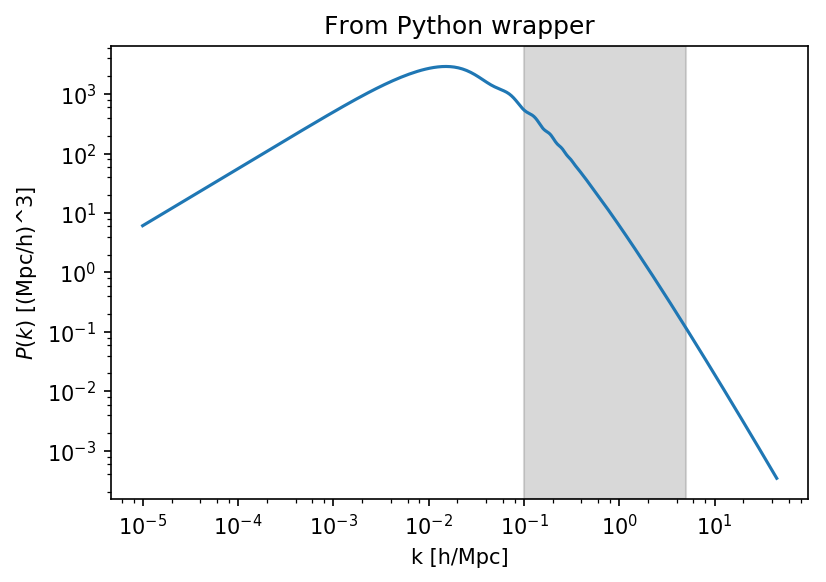

In [6]:
## Plot power spectrum from python
plt.figure()
plt.loglog(kh_py,Ph_py[0])
plt.title(r"From Python wrapper")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P(k)$ [(Mpc/h)^3]")
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

### Now call Fortran version of CAMB, and read power spectrum from file 

In [7]:
import subprocess
# need to have CAMBEXEC defined in .bashrc or similar
camb_exec= os.environ['CAMBEXEC']
print('CAMB exec =',camb_exec)
camb_call=[camb_exec,'params_ref.ini']
p = subprocess.Popen(camb_call,stderr=subprocess.PIPE,stdout=subprocess.PIPE)
#p = subprocess.Popen(camb_call)
camb_stdout,camb_stderr = p.communicate()
if p.returncode:
    print('CAMB exited with returncode',p.returncode)
    print('stdout',camb_stdout)
    print('stderr',camb_stderr)

CAMB exec = /Users/font/Programs/Others/CAMB-Jan2017/camb


In [8]:
# will read Pk from this file
pk_file='test_matterpower.dat'
# note that units are in Mpc/h
kh_F, Ph_F = np.loadtxt(pk_file, unpack=True)
print('# lines =',len(kh_F))
print(np.min(kh_F),'< k [h/Mpc] <',np.max(kh_F))

# lines = 194
7.1429e-05 < k [h/Mpc] < 21.719


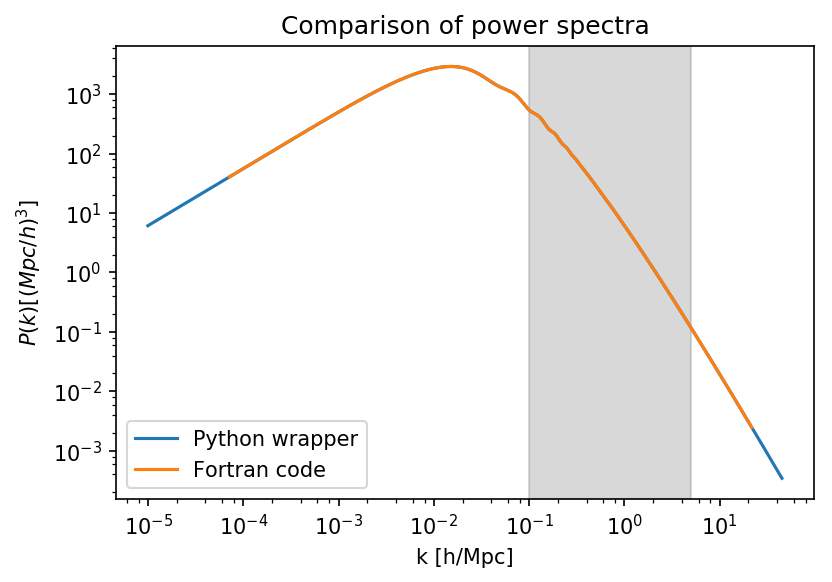

In [9]:
## Plot both power spectra
plt.figure()
plt.loglog(kh_py,Ph_py[0],label="Python wrapper")
plt.loglog(kh_F,Ph_F,label="Fortran code")
plt.title(r"Comparison of power spectra")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P(k) [(Mpc/h)^3]$")
plt.legend(loc="best")
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')
#plt.ylim([1.e-3,1.e5])
#plt.xlim([1.e-3,10.0])
#plt.show("hold")

### Compare both power spectra by looking at ratio (will need to interpolate)

In [10]:
# mask kh_F elements outside range covered by kh_py (interp would crash)
mask=(kh_F > kh_py[0]) & (kh_F < kh_py[-1])
kh_F=kh_F[mask]
Ph_F=Ph_F[mask]

(0.995, 1.005)

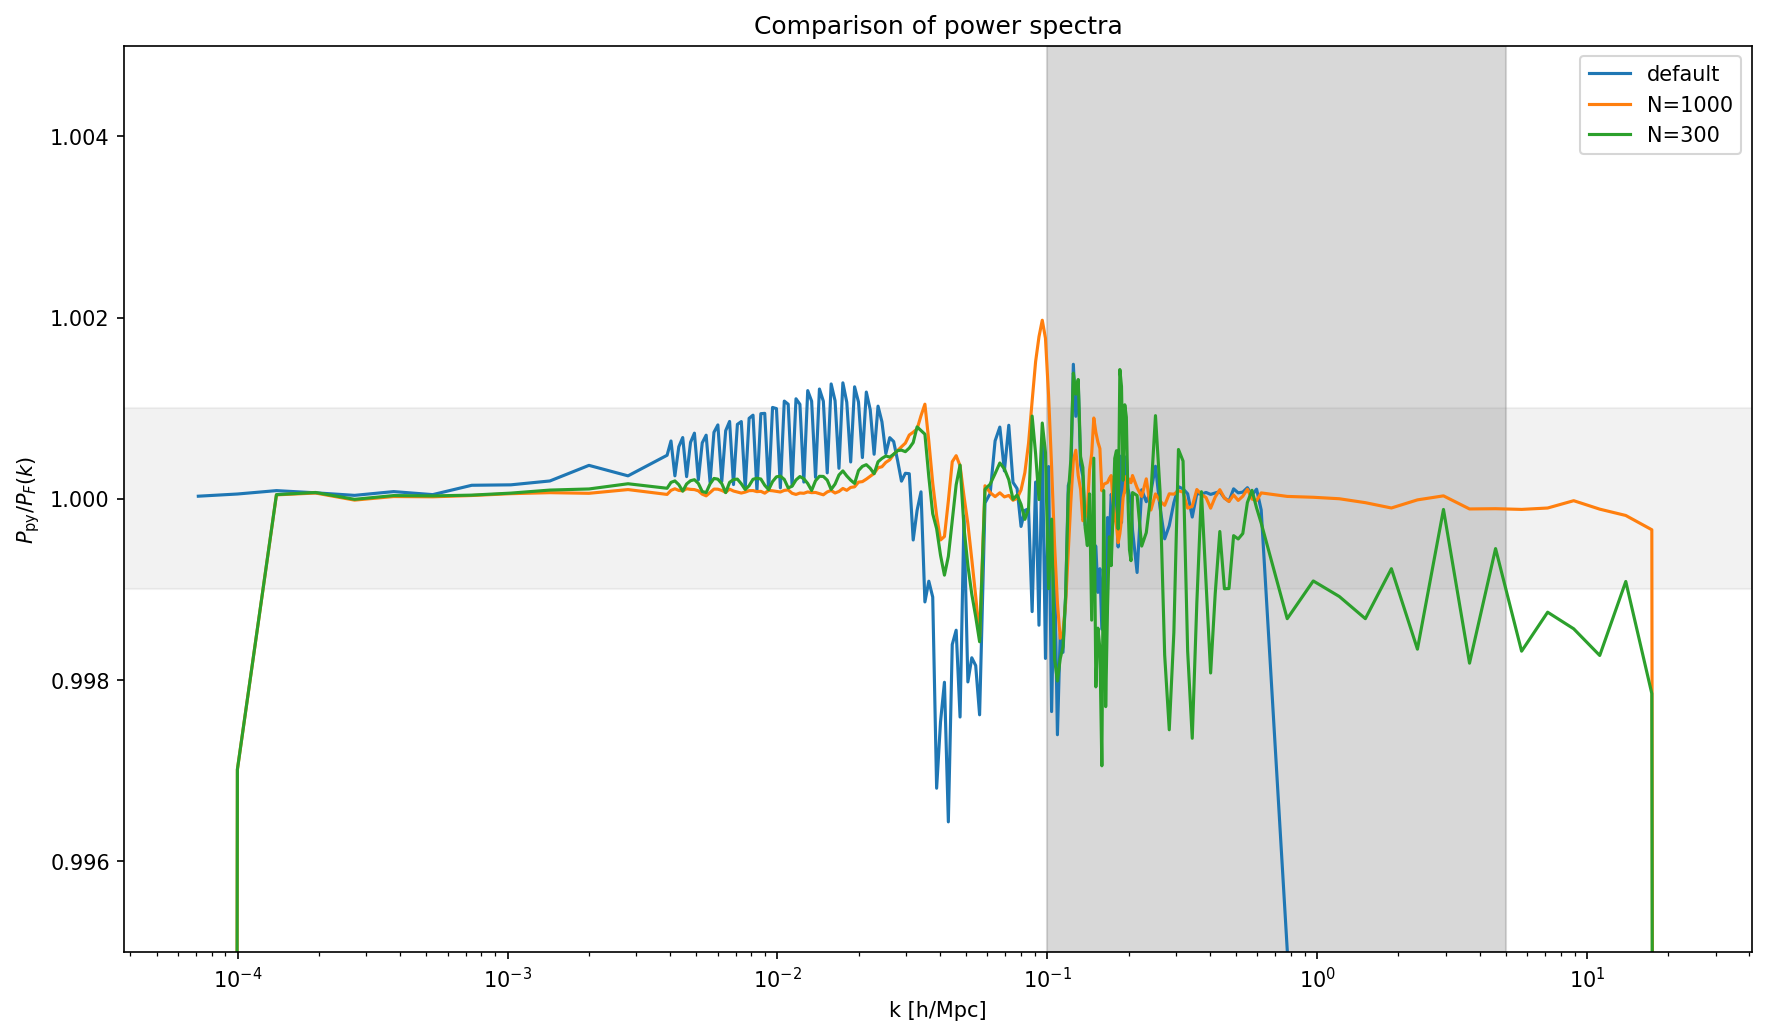

In [11]:
plt.figure(figsize=[14,8])
plt.semilogx(kh_F,Ph_F/np.interp(kh_F,kh_py,Ph_py[0]),label='default')
plt.semilogx(kh_F,Ph_F/np.interp(kh_F,kh_py_1000,Ph_py_1000[0]),label='N=1000')
plt.semilogx(kh_F,Ph_F/np.interp(kh_F,kh_py_300,Ph_py_300[0]),label='N=300')
plt.legend()
plt.title(r"Comparison of power spectra")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P_{\rm py} / P_F(k)$")
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')
plt.axhspan(0.999,1.001,alpha=0.1, color='gray')
plt.ylim([0.995,1.005])

(0.01, 20.0)

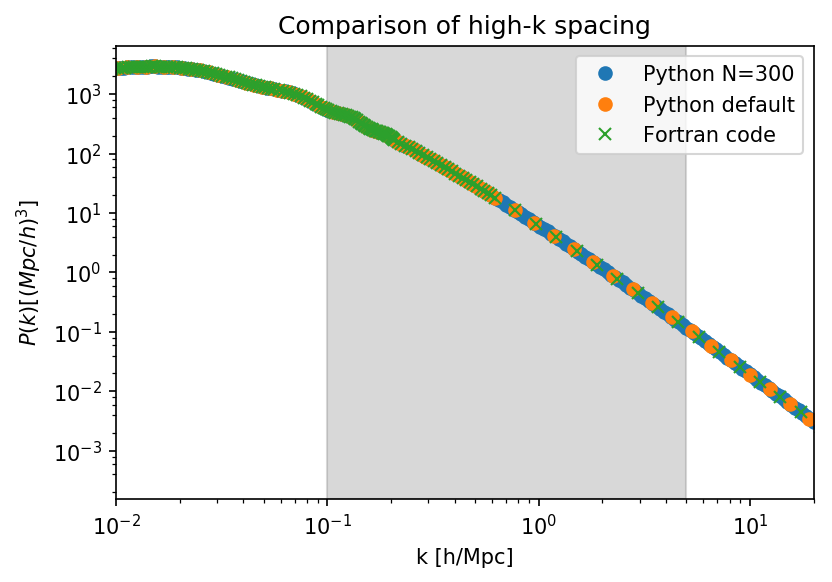

In [12]:
## Look at high-k spacing
plt.figure()
plt.loglog(kh_py_300,Ph_py_300[0],'o',label="Python N=300")
plt.loglog(kh_py,Ph_py[0],'o',label="Python default")
plt.loglog(kh_F,Ph_F,'x',label="Fortran code")
plt.title(r"Comparison of high-k spacing")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P(k) [(Mpc/h)^3]$")
plt.legend(loc="best")
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')
#plt.ylim([1.e-3,1.e5])
plt.xlim([1.e-2,20.0])
#plt.show("hold")